## Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import math

import sklearn
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score, precision_score,confusion_matrix, recall_score, roc_auc_score
#for bayesian optimization
#!pip install scikit-optimize
import skopt
from skopt import gbrt_minimize, gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Categorical, Integer

In [2]:
data_path = "https://raw.githubusercontent.com/shadow23-cmi/Data-Driven-Prediction-of-Fraudulent-Firm/main/Data.csv"
data = pd.read_csv(data_path)
data.head()

,Sector_score,LOCATION_ID,PARA_A,SCORE_A,PARA_B,SCORE_B,TOTAL,numbers,Marks,Money_Value,MONEY_Marks,District,Loss,LOSS_SCORE,History,History_score,Score,Risk
0,3.89,23,4.18,6,2.50,2,6.68,5.0,2,3.38,2,2,0,2,0,2,2.4,1
1,3.89,6,0.00,2,4.83,2,4.83,5.0,2,0.94,2,2,0,2,0,2,2.0,0
2,3.89,6,0.51,2,0.23,2,0.74,5.0,2,0.00,2,2,0,2,0,2,2.0,0
3,3.89,6,0.00,2,10.80,6,10.80,6.0,6,11.75,6,2,0,2,0,2,4.4,1
4,3.89,6,0.00,2,0.08,2,0.08,5.0,2,0.00,2,2,0,2,0,2,2.0,0


In [3]:
to_drop = ["SCORE_A","SCORE_B","Marks","MONEY_Marks","LOSS_SCORE","History_score","Score"]
for column in to_drop:
    data.drop(column,inplace = True,axis = 1)

In [4]:
data.head()

,Sector_score,LOCATION_ID,PARA_A,PARA_B,TOTAL,numbers,Money_Value,District,Loss,History,Risk
0,3.89,23,4.18,2.50,6.68,5.0,3.38,2,0,0,1
1,3.89,6,0.00,4.83,4.83,5.0,0.94,2,0,0,0
2,3.89,6,0.51,0.23,0.74,5.0,0.00,2,0,0,0
3,3.89,6,0.00,10.80,10.80,6.0,11.75,2,0,0,1
4,3.89,6,0.00,0.08,0.08,5.0,0.00,2,0,0,0


In [5]:
data[data.Money_Value.isnull()]

,Sector_score,LOCATION_ID,PARA_A,PARA_B,TOTAL,numbers,Money_Value,District,Loss,History,Risk
642,55.57,4,0.23,0.0,0.23,5.0,NaN,2,0,0,0


In [6]:
data["Money_Value"][642]=0
#data["Money_Value"].fillna((data["Money_Value"].mode()),inplace=True)

<ipython-input-6-fcbcd43c364e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Money_Value"][642]=0


In [7]:
data.head()

,Sector_score,LOCATION_ID,PARA_A,PARA_B,TOTAL,numbers,Money_Value,District,Loss,History,Risk
0,3.89,23,4.18,2.50,6.68,5.0,3.38,2,0,0,1
1,3.89,6,0.00,4.83,4.83,5.0,0.94,2,0,0,0
2,3.89,6,0.51,0.23,0.74,5.0,0.00,2,0,0,0
3,3.89,6,0.00,10.80,10.80,6.0,11.75,2,0,0,1
4,3.89,6,0.00,0.08,0.08,5.0,0.00,2,0,0,0


In [8]:
print(set(data.LOCATION_ID))

{'41', '13', '16', '28', '8', '20', '15', '36', '1', '6', '23', 'SAFIDON', '5', '9', '25', '4', '31', '24', '44', '2', '18', '38', 'NUH', '27', '39', '17', '3', '42', '7', '35', '21', '22', '29', '14', '32', '34', '30', '43', '40', '12', '33', '19', '11', 'LOHARU', '37'}


In [9]:
data=data.replace({"LOHARU":10,
                   "NUH":26,
                   "SAFIDON":45})
data.LOCATION_ID=data.LOCATION_ID.astype(int)
print(set(data.LOCATION_ID))

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45}


### Creating feature and target from dataset

In [10]:
target=data["Risk"].to_numpy()
feature=data.drop(["Risk"],axis=1).to_numpy()

In [11]:
sc_X = StandardScaler()
feature_scaled = pd.DataFrame(sc_X.fit_transform(feature))

In [12]:
X_train,X_test,y_train,y_test=train_test_split(feature,
                                               target,
                                               test_size=0.2,
                                               shuffle=True)

In [13]:
decision_tree=sklearn.tree.DecisionTreeClassifier(criterion="entropy",
                                                  max_depth=4,
                                                  min_samples_leaf=25,
                                                  class_weight={1:1,0:1})

In [14]:
decision_tree.fit(X_train,y_train)


DecisionTreeClassifier(class_weight={0: 1, 1: 1}, criterion='entropy',
                       max_depth=4, min_samples_leaf=25)

[Text(239.14285714285714, 195.696, 'X[2] <= 0.985\nentropy = 0.954\nsamples = 620\nvalue = [232, 388]'),
 Text(191.31428571428572, 152.208, 'X[7] <= 3.0\nentropy = 0.875\nsamples = 329\nvalue = [232, 97]'),
 Text(143.4857142857143, 108.72, 'X[4] <= 1.805\nentropy = 0.674\nsamples = 282\nvalue = [232, 50]'),
 Text(95.65714285714286, 65.232, 'X[6] <= 1.14\nentropy = 0.347\nsamples = 246\nvalue = [230, 16]'),
 Text(47.82857142857143, 21.744, 'entropy = 0.159\nsamples = 215\nvalue = [210, 5]'),
 Text(143.4857142857143, 21.744, 'entropy = 0.938\nsamples = 31\nvalue = [20, 11]'),
 Text(191.31428571428572, 65.232, 'entropy = 0.31\nsamples = 36\nvalue = [2, 34]'),
 Text(239.14285714285714, 108.72, 'entropy = 0.0\nsamples = 47\nvalue = [0, 47]'),
 Text(286.9714285714286, 152.208, 'entropy = 0.0\nsamples = 291\nvalue = [0, 291]')]

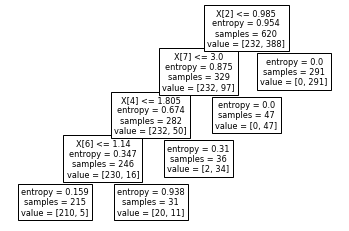

In [15]:
tree.plot_tree(decision_tree) 

In [16]:
#CROSS-VALIDATION

crs=cross_validate(decision_tree,
                   X_train,
                   y_train,
                   cv=10,
                   scoring=["recall","precision","accuracy","f1"],
                   n_jobs=2)

#printing output:

print("\nFor Decision Tree ,\n")
print("\t After cross validation the  different scores are as follows:")
print("recall:",crs["test_recall"],"\n",
      "precision:",crs["test_precision"],"\n",
      "accuracy:",crs["test_accuracy"],"\n",
      "fscore:",crs["test_f1"],"\n")
print("recall mean   :", crs["test_recall"].mean(),"with starderd deviation:",crs["test_recall"].std())
print("precision mean:",crs["test_precision"].mean(),"with starderd deviation:",crs["test_precision"].std())
print("accuracy mean :",crs["test_accuracy"].mean(),"with starderd deviation:",crs["test_accuracy"].std())
print("fscore   mean :",crs["test_f1"].mean(),"with starderd deviation:",crs["test_f1"].std())




For Decision Tree ,

	 After cross validation the  different scores are as follows:
recall: [0.94871795 1.         0.97435897 0.94871795 0.94871795 0.94871795
 0.97435897 0.94871795 0.94736842 0.92105263] 
 precision: [1.         0.975      0.97435897 1.         0.97368421 0.97368421
 1.         1.         0.97297297 1.        ] 
 accuracy: [0.96774194 0.98387097 0.96774194 0.96774194 0.9516129  0.9516129
 0.98387097 0.96774194 0.9516129  0.9516129 ] 
 fscore: [0.97368421 0.98734177 0.97435897 0.97368421 0.96103896 0.96103896
 0.98701299 0.97368421 0.96       0.95890411] 

recall mean   : 0.9560728744939271 with starderd deviation: 0.0204230625547734
precision mean: 0.986970036838458 with starderd deviation: 0.013039035766414919
accuracy mean : 0.964516129032258 with starderd deviation: 0.012069862537980446
fscore   mean : 0.9710748396769769 with starderd deviation: 0.010109728417538025


In [17]:
decision_tree.fit(X_train, y_train)
y_predict_r = decision_tree.predict(X_test)
print(type(y_predict_r),type(y_test))
roc=roc_auc_score(y_test, y_predict_r)
acc = accuracy_score(list(y_test), list(y_predict_r))
prec = precision_score(y_test, y_predict_r)
rec = recall_score(y_test, y_predict_r)
f1 = f1_score(y_test, y_predict_r)
model_results = pd.DataFrame([['decision_tree',acc, crs["test_accuracy"].mean(),prec,rec, f1,roc]],
               columns = ['Model', 'Accuracy','Cross Val Accuracy', 'Precision', 'Recall', 'F1 Score','ROC'])
#results = results.append(model_results, ignore_index = True)
model_results

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


,Model,Accuracy,Cross Val Accuracy,Precision,Recall,F1 Score,ROC
0,decision_tree,0.929487,0.964516,0.967742,0.918367,0.942408,0.933322


## Decision Tree with bayesian optimization

In [18]:
X_train,X_test,y_train,y_test=train_test_split(feature,
                                               target,
                                               test_size=0.2,
                                               shuffle=True)

In [19]:
dim_criterion = Categorical(categories=['entropy', 'gini'],
                             name='criterion')
dim_max_depth = Integer(low=2, high=8, name="max_depth")
dim_min_samples_leaf = Integer(low=20, high= 50, name="min_samples_leaf")
dim_class_weight = Real(low=1.0, high= 2.0,name="class_weight")

dimensions=[dim_criterion,
            dim_max_depth,
            dim_min_samples_leaf,
            dim_class_weight]

default_parameters = ["gini", 4, 25, 1.2]

In [20]:
def create_model(criterion,
                max_depth,
                min_samples_leaf,
                class_weight):
    decision_tree=sklearn.tree.DecisionTreeClassifier(criterion = criterion,
                                                  max_depth = max_depth,
                                                  min_samples_leaf = min_samples_leaf,
                                                  class_weight={1:class_weight,0:1})
    return decision_tree

In [21]:
@use_named_args(dimensions=dimensions)
def fitness(criterion,
                max_depth,
                min_samples_leaf,
                class_weight):
    model = create_model(criterion = criterion,
                        max_depth = max_depth,
                        min_samples_leaf = min_samples_leaf,
                        class_weight = class_weight)
    #model.fit(feature,target)
    crs=cross_validate(model,
                       feature_scaled,
                       target,
                       cv=10,
                       scoring=["recall","precision","accuracy","f1"],
                       n_jobs=2)
    
    print("recall mean   :", round(crs["test_recall"].mean(),2),"with starderd deviation:",round(crs["test_recall"].std(),3))
    print("precision mean:",round(crs["test_precision"].mean(),2),"with starderd deviation:",round(crs["test_precision"].std(),3))
    print("accuracy mean :",round(crs["test_accuracy"].mean(),2),"with starderd deviation:",round(crs["test_accuracy"].std(),3))
    print("fscore   mean :",round(crs["test_f1"].mean(),2),"with starderd deviation:",round(crs["test_f1"].std(),3))
    print("\n\n")
    return -(crs["test_accuracy"].mean() * crs["test_recall"].mean())

In [22]:
gp_result = gp_minimize(func=fitness,
                        dimensions=dimensions,
                        n_calls=50,
                        n_jobs=2,
                        x0=default_parameters)

recall mean   : 0.95 with starderd deviation: 0.04
precision mean: 0.96 with starderd deviation: 0.062
accuracy mean : 0.94 with starderd deviation: 0.052
fscore   mean : 0.96 with starderd deviation: 0.038



recall mean   : 0.95 with starderd deviation: 0.036
precision mean: 0.94 with starderd deviation: 0.072
accuracy mean : 0.93 with starderd deviation: 0.059
fscore   mean : 0.95 with starderd deviation: 0.043



recall mean   : 0.89 with starderd deviation: 0.113
precision mean: 0.97 with starderd deviation: 0.07
accuracy mean : 0.91 with starderd deviation: 0.081
fscore   mean : 0.92 with starderd deviation: 0.071



recall mean   : 0.96 with starderd deviation: 0.036
precision mean: 0.97 with starderd deviation: 0.067
accuracy mean : 0.95 with starderd deviation: 0.06
fscore   mean : 0.96 with starderd deviation: 0.044



recall mean   : 0.88 with starderd deviation: 0.111
precision mean: 0.92 with starderd deviation: 0.105
accuracy mean : 0.86 with starderd deviation: 0.086
fsc

recall mean   : 0.85 with starderd deviation: 0.119
precision mean: 0.97 with starderd deviation: 0.069
accuracy mean : 0.88 with starderd deviation: 0.077
fscore   mean : 0.9 with starderd deviation: 0.071



recall mean   : 0.95 with starderd deviation: 0.04
precision mean: 0.97 with starderd deviation: 0.062
accuracy mean : 0.95 with starderd deviation: 0.057
fscore   mean : 0.96 with starderd deviation: 0.043



recall mean   : 0.96 with starderd deviation: 0.04
precision mean: 0.96 with starderd deviation: 0.06
accuracy mean : 0.95 with starderd deviation: 0.055
fscore   mean : 0.96 with starderd deviation: 0.04



recall mean   : 0.95 with starderd deviation: 0.04
precision mean: 0.97 with starderd deviation: 0.062
accuracy mean : 0.95 with starderd deviation: 0.054
fscore   mean : 0.96 with starderd deviation: 0.04





/home/suman/anaconda3/envs/tf/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


recall mean   : 0.98 with starderd deviation: 0.038
precision mean: 0.94 with starderd deviation: 0.068
accuracy mean : 0.94 with starderd deviation: 0.052
fscore   mean : 0.96 with starderd deviation: 0.036



recall mean   : 0.95 with starderd deviation: 0.04
precision mean: 0.97 with starderd deviation: 0.066
accuracy mean : 0.95 with starderd deviation: 0.06
fscore   mean : 0.96 with starderd deviation: 0.044



recall mean   : 0.89 with starderd deviation: 0.113
precision mean: 0.93 with starderd deviation: 0.119
accuracy mean : 0.88 with starderd deviation: 0.113
fscore   mean : 0.9 with starderd deviation: 0.084



recall mean   : 0.96 with starderd deviation: 0.04
precision mean: 0.96 with starderd deviation: 0.06
accuracy mean : 0.95 with starderd deviation: 0.055
fscore   mean : 0.96 with starderd deviation: 0.04



recall mean   : 0.96 with starderd deviation: 0.041
precision mean: 0.96 with starderd deviation: 0.06
accuracy mean : 0.95 with starderd deviation: 0.057
fscore 

/home/suman/anaconda3/envs/tf/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


recall mean   : 0.98 with starderd deviation: 0.033
precision mean: 0.94 with starderd deviation: 0.068
accuracy mean : 0.94 with starderd deviation: 0.051
fscore   mean : 0.96 with starderd deviation: 0.035



recall mean   : 0.94 with starderd deviation: 0.071
precision mean: 0.93 with starderd deviation: 0.104
accuracy mean : 0.91 with starderd deviation: 0.111
fscore   mean : 0.93 with starderd deviation: 0.083





In [23]:
print(gp_result.x)

['entropy', 8, 20, 1.702467131718288]


In [24]:
model = create_model(gp_result.x[0],gp_result.x[1],gp_result.x[2],gp_result.x[3])
#fit=model.fit(X_train,y_train)
#CROSS-VALIDATION

crs=cross_validate(model,
                   X_train,
                   y_train,
                   cv=10,
                   scoring=["recall","precision","accuracy","f1"],
                   n_jobs=2)

#printing output:

print("\nFor Decision Tree ,\n")
print("\t After cross validation the  different scores are as follows:")
print("recall:",crs["test_recall"],"\n",
      "precision:",crs["test_precision"],"\n",
      "accuracy:",crs["test_accuracy"],"\n",
      "fscore:",crs["test_f1"],"\n")
print("recall mean   :", crs["test_recall"].mean(),"with starderd deviation:",crs["test_recall"].std())
print("precision mean:",crs["test_precision"].mean(),"with starderd deviation:",crs["test_precision"].std())
print("accuracy mean :",crs["test_accuracy"].mean(),"with starderd deviation:",crs["test_accuracy"].std())
print("fscore   mean :",crs["test_f1"].mean(),"with starderd deviation:",crs["test_f1"].std())




For Decision Tree ,

	 After cross validation the  different scores are as follows:
recall: [1.         0.94736842 0.94871795 0.97435897 0.97435897 1.
 1.         1.         1.         1.        ] 
 precision: [0.95       0.94736842 0.925      0.95       0.9047619  0.975
 0.95121951 0.95121951 0.95121951 0.95121951] 
 accuracy: [0.96774194 0.93548387 0.91935484 0.9516129  0.91935484 0.98387097
 0.96774194 0.96774194 0.96774194 0.96774194] 
 fscore: [0.97435897 0.94736842 0.93670886 0.96202532 0.9382716  0.98734177
 0.975      0.975      0.975      0.975     ] 

recall mean   : 0.9844804318488528 with starderd deviation: 0.020751593485933785
precision mean: 0.9457008374595024 with starderd deviation: 0.017676343861237905
accuracy mean : 0.9548387096774196 with starderd deviation: 0.02139757929261551
fscore   mean : 0.9646074949716965 with starderd deviation: 0.016792026567494598


In [25]:
model.fit(X_train, y_train)
y_predict_r = model.predict(X_test)
roc=roc_auc_score(y_test, y_predict_r)
acc = accuracy_score(list(y_test), list(y_predict_r))
prec = precision_score(y_test, y_predict_r)
rec = recall_score(y_test, y_predict_r)
f1 = f1_score(y_test, y_predict_r)
results = pd.DataFrame([['decision_tree', crs["test_accuracy"].mean(),acc,crs["test_recall"].mean(),rec, f1]],
               columns = ['Model', 'Cross Val Accuracy','Accuracy', 'Cross val FRecall', 'Recall', 'F1 Score'])
#results = results.append(model_results, ignore_index = True)
results

,Model,Cross Val Accuracy,Accuracy,Cross val FRecall,Recall,F1 Score
0,decision_tree,0.954839,0.967949,0.98448,1.0,0.975124


[Text(231.7846153846154, 203.85, 'X[2] <= 0.97\nentropy = 0.827\nsamples = 620\nvalue = [232.0, 660.557]'),
 Text(180.27692307692308, 176.67000000000002, 'X[7] <= 3.0\nentropy = 0.978\nsamples = 328\nvalue = [232.0, 163.437]'),
 Text(154.52307692307693, 149.49, 'X[3] <= 1.05\nentropy = 0.861\nsamples = 286\nvalue = [232.0, 91.933]'),
 Text(103.01538461538462, 122.31, 'X[6] <= 1.83\nentropy = 0.526\nsamples = 245\nvalue = [227.0, 30.644]'),
 Text(77.26153846153846, 95.13, 'X[4] <= 1.265\nentropy = 0.265\nsamples = 223\nvalue = [217.0, 10.215]'),
 Text(51.50769230769231, 67.94999999999999, 'X[1] <= 4.5\nentropy = 0.168\nsamples = 203\nvalue = [200.0, 5.107]'),
 Text(25.753846153846155, 40.77000000000001, 'entropy = 0.615\nsamples = 21\nvalue = [19.0, 3.405]'),
 Text(77.26153846153846, 40.77000000000001, 'X[1] <= 30.5\nentropy = 0.076\nsamples = 182\nvalue = [181.0, 1.702]'),
 Text(51.50769230769231, 13.590000000000003, 'entropy = 0.0\nsamples = 162\nvalue = [162, 0]'),
 Text(103.01538461

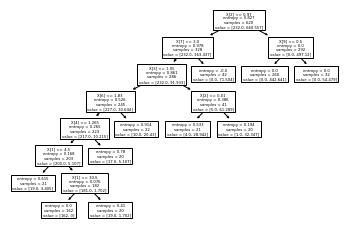

In [26]:
model.fit(X_train,y_train)

tree.plot_tree(model) 

# Fitting SVM

### Bayesian Optimization

In [27]:
X_train,X_test,y_train,y_test=train_test_split(feature,
                                               target,
                                               test_size=0.2,
                                               shuffle=True)

In [28]:
dim_kernel = Categorical(categories=["linear", "poly", "rbf", "sigmoid"],
                             name='kernel')
dim_degree = Integer(low=1, high=5, name="degree")

dim_class_weight = Real(low=1.0, high= 2.0,name="class_weight")

dimensions=[dim_kernel,
            dim_degree,
            dim_class_weight]

default_parameters = ["rbf", 2, 1.2]

In [29]:
def create_model(kernel,
                degree,
                class_weight):
    svc=sklearn.svm.SVC(kernel=kernel,
                        degree=degree,
                        class_weight={1:class_weight,0:1})
    return svc

In [30]:
@use_named_args(dimensions=dimensions)
def fitness(kernel,
            degree,
            class_weight):
    model = create_model(kernel = kernel,
                        degree = degree,
                        class_weight = class_weight)
    #model.fit(feature,target)
    crs=cross_validate(model,
                       feature,
                       target,
                       cv=10,
                       scoring=["recall","precision","accuracy","f1"],
                       n_jobs=2)
    
    print("recall mean   :", round(crs["test_recall"].mean(),2),"with starderd deviation:",round(crs["test_recall"].std(),3))
    print("precision mean:",round(crs["test_precision"].mean(),2),"with starderd deviation:",round(crs["test_precision"].std(),3))
    print("accuracy mean :",round(crs["test_accuracy"].mean(),2),"with starderd deviation:",round(crs["test_accuracy"].std(),3))
    print("fscore   mean :",round(crs["test_f1"].mean(),2),"with starderd deviation:",round(crs["test_f1"].std(),3))
    print("\n\n")
    
    return -(crs["test_accuracy"].mean() * crs["test_recall"].mean())

In [31]:
gp_result = gp_minimize(func=fitness,
                        dimensions=dimensions,
                        n_calls=50,
                        n_jobs=2,
                        x0=default_parameters)

recall mean   : 0.81 with starderd deviation: 0.379
precision mean: 0.83 with starderd deviation: 0.173
accuracy mean : 0.72 with starderd deviation: 0.215
fscore   mean : 0.72 with starderd deviation: 0.324



recall mean   : 0.96 with starderd deviation: 0.099
precision mean: 0.94 with starderd deviation: 0.044
accuracy mean : 0.94 with starderd deviation: 0.055
fscore   mean : 0.95 with starderd deviation: 0.053



recall mean   : 0.96 with starderd deviation: 0.099
precision mean: 0.94 with starderd deviation: 0.044
accuracy mean : 0.94 with starderd deviation: 0.055
fscore   mean : 0.95 with starderd deviation: 0.053



recall mean   : 0.95 with starderd deviation: 0.096
precision mean: 0.96 with starderd deviation: 0.035
accuracy mean : 0.94 with starderd deviation: 0.054
fscore   mean : 0.95 with starderd deviation: 0.053



recall mean   : 0.81 with starderd deviation: 0.379
precision mean: 0.83 with starderd deviation: 0.172
accuracy mean : 0.72 with starderd deviation: 0.216


/home/suman/anaconda3/envs/tf/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


recall mean   : 0.96 with starderd deviation: 0.094
precision mean: 0.94 with starderd deviation: 0.046
accuracy mean : 0.94 with starderd deviation: 0.053
fscore   mean : 0.95 with starderd deviation: 0.049



recall mean   : 0.93 with starderd deviation: 0.104
precision mean: 0.97 with starderd deviation: 0.03
accuracy mean : 0.94 with starderd deviation: 0.059
fscore   mean : 0.94 with starderd deviation: 0.06



recall mean   : 0.96 with starderd deviation: 0.1
precision mean: 0.94 with starderd deviation: 0.046
accuracy mean : 0.94 with starderd deviation: 0.056
fscore   mean : 0.95 with starderd deviation: 0.053



recall mean   : 0.95 with starderd deviation: 0.098
precision mean: 0.95 with starderd deviation: 0.04
accuracy mean : 0.94 with starderd deviation: 0.054
fscore   mean : 0.95 with starderd deviation: 0.052





/home/suman/anaconda3/envs/tf/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


recall mean   : 0.96 with starderd deviation: 0.094
precision mean: 0.94 with starderd deviation: 0.046
accuracy mean : 0.94 with starderd deviation: 0.053
fscore   mean : 0.95 with starderd deviation: 0.049





/home/suman/anaconda3/envs/tf/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


recall mean   : 0.96 with starderd deviation: 0.094
precision mean: 0.94 with starderd deviation: 0.046
accuracy mean : 0.94 with starderd deviation: 0.053
fscore   mean : 0.95 with starderd deviation: 0.049



recall mean   : 0.96 with starderd deviation: 0.1
precision mean: 0.94 with starderd deviation: 0.046
accuracy mean : 0.94 with starderd deviation: 0.056
fscore   mean : 0.95 with starderd deviation: 0.053





/home/suman/anaconda3/envs/tf/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


recall mean   : 0.96 with starderd deviation: 0.094
precision mean: 0.94 with starderd deviation: 0.046
accuracy mean : 0.94 with starderd deviation: 0.053
fscore   mean : 0.95 with starderd deviation: 0.049



recall mean   : 0.82 with starderd deviation: 0.368
precision mean: 0.7 with starderd deviation: 0.149
accuracy mean : 0.59 with starderd deviation: 0.081
fscore   mean : 0.65 with starderd deviation: 0.254





/home/suman/anaconda3/envs/tf/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


recall mean   : 0.96 with starderd deviation: 0.094
precision mean: 0.94 with starderd deviation: 0.046
accuracy mean : 0.94 with starderd deviation: 0.053
fscore   mean : 0.95 with starderd deviation: 0.049





/home/suman/anaconda3/envs/tf/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


recall mean   : 0.96 with starderd deviation: 0.094
precision mean: 0.94 with starderd deviation: 0.046
accuracy mean : 0.94 with starderd deviation: 0.053
fscore   mean : 0.95 with starderd deviation: 0.049



recall mean   : 0.82 with starderd deviation: 0.368
precision mean: 0.7 with starderd deviation: 0.149
accuracy mean : 0.59 with starderd deviation: 0.081
fscore   mean : 0.65 with starderd deviation: 0.254





/home/suman/anaconda3/envs/tf/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


recall mean   : 0.96 with starderd deviation: 0.094
precision mean: 0.94 with starderd deviation: 0.046
accuracy mean : 0.94 with starderd deviation: 0.053
fscore   mean : 0.95 with starderd deviation: 0.049





/home/suman/anaconda3/envs/tf/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


recall mean   : 0.96 with starderd deviation: 0.094
precision mean: 0.94 with starderd deviation: 0.046
accuracy mean : 0.94 with starderd deviation: 0.053
fscore   mean : 0.95 with starderd deviation: 0.049



recall mean   : 0.94 with starderd deviation: 0.096
precision mean: 0.96 with starderd deviation: 0.033
accuracy mean : 0.94 with starderd deviation: 0.053
fscore   mean : 0.95 with starderd deviation: 0.052





/home/suman/anaconda3/envs/tf/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


recall mean   : 0.96 with starderd deviation: 0.094
precision mean: 0.94 with starderd deviation: 0.046
accuracy mean : 0.94 with starderd deviation: 0.053
fscore   mean : 0.95 with starderd deviation: 0.049





/home/suman/anaconda3/envs/tf/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


recall mean   : 0.96 with starderd deviation: 0.094
precision mean: 0.94 with starderd deviation: 0.046
accuracy mean : 0.94 with starderd deviation: 0.053
fscore   mean : 0.95 with starderd deviation: 0.049





/home/suman/anaconda3/envs/tf/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


recall mean   : 0.96 with starderd deviation: 0.094
precision mean: 0.94 with starderd deviation: 0.046
accuracy mean : 0.94 with starderd deviation: 0.053
fscore   mean : 0.95 with starderd deviation: 0.049





/home/suman/anaconda3/envs/tf/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


recall mean   : 0.96 with starderd deviation: 0.094
precision mean: 0.94 with starderd deviation: 0.046
accuracy mean : 0.94 with starderd deviation: 0.053
fscore   mean : 0.95 with starderd deviation: 0.049





/home/suman/anaconda3/envs/tf/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


recall mean   : 0.96 with starderd deviation: 0.094
precision mean: 0.94 with starderd deviation: 0.046
accuracy mean : 0.94 with starderd deviation: 0.053
fscore   mean : 0.95 with starderd deviation: 0.049



recall mean   : 0.93 with starderd deviation: 0.104
precision mean: 0.97 with starderd deviation: 0.03
accuracy mean : 0.94 with starderd deviation: 0.059
fscore   mean : 0.94 with starderd deviation: 0.06





/home/suman/anaconda3/envs/tf/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


recall mean   : 0.96 with starderd deviation: 0.094
precision mean: 0.94 with starderd deviation: 0.046
accuracy mean : 0.94 with starderd deviation: 0.053
fscore   mean : 0.95 with starderd deviation: 0.049





/home/suman/anaconda3/envs/tf/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


recall mean   : 0.96 with starderd deviation: 0.094
precision mean: 0.94 with starderd deviation: 0.046
accuracy mean : 0.94 with starderd deviation: 0.053
fscore   mean : 0.95 with starderd deviation: 0.049





/home/suman/anaconda3/envs/tf/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


recall mean   : 0.96 with starderd deviation: 0.094
precision mean: 0.94 with starderd deviation: 0.046
accuracy mean : 0.94 with starderd deviation: 0.053
fscore   mean : 0.95 with starderd deviation: 0.049





/home/suman/anaconda3/envs/tf/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


recall mean   : 0.96 with starderd deviation: 0.094
precision mean: 0.94 with starderd deviation: 0.046
accuracy mean : 0.94 with starderd deviation: 0.053
fscore   mean : 0.95 with starderd deviation: 0.049





/home/suman/anaconda3/envs/tf/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


recall mean   : 0.96 with starderd deviation: 0.094
precision mean: 0.94 with starderd deviation: 0.046
accuracy mean : 0.94 with starderd deviation: 0.053
fscore   mean : 0.95 with starderd deviation: 0.049





/home/suman/anaconda3/envs/tf/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


recall mean   : 0.96 with starderd deviation: 0.094
precision mean: 0.94 with starderd deviation: 0.046
accuracy mean : 0.94 with starderd deviation: 0.053
fscore   mean : 0.95 with starderd deviation: 0.049





/home/suman/anaconda3/envs/tf/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


recall mean   : 0.96 with starderd deviation: 0.094
precision mean: 0.94 with starderd deviation: 0.046
accuracy mean : 0.94 with starderd deviation: 0.053
fscore   mean : 0.95 with starderd deviation: 0.049





/home/suman/anaconda3/envs/tf/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


recall mean   : 0.93 with starderd deviation: 0.104
precision mean: 0.97 with starderd deviation: 0.03
accuracy mean : 0.94 with starderd deviation: 0.059
fscore   mean : 0.94 with starderd deviation: 0.06





/home/suman/anaconda3/envs/tf/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


recall mean   : 0.96 with starderd deviation: 0.094
precision mean: 0.94 with starderd deviation: 0.046
accuracy mean : 0.94 with starderd deviation: 0.053
fscore   mean : 0.95 with starderd deviation: 0.049





/home/suman/anaconda3/envs/tf/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


recall mean   : 0.96 with starderd deviation: 0.094
precision mean: 0.94 with starderd deviation: 0.046
accuracy mean : 0.94 with starderd deviation: 0.053
fscore   mean : 0.95 with starderd deviation: 0.049





/home/suman/anaconda3/envs/tf/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


recall mean   : 0.96 with starderd deviation: 0.094
precision mean: 0.94 with starderd deviation: 0.046
accuracy mean : 0.94 with starderd deviation: 0.053
fscore   mean : 0.95 with starderd deviation: 0.049





/home/suman/anaconda3/envs/tf/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


recall mean   : 0.96 with starderd deviation: 0.094
precision mean: 0.94 with starderd deviation: 0.046
accuracy mean : 0.94 with starderd deviation: 0.053
fscore   mean : 0.95 with starderd deviation: 0.049





/home/suman/anaconda3/envs/tf/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


recall mean   : 0.96 with starderd deviation: 0.094
precision mean: 0.94 with starderd deviation: 0.046
accuracy mean : 0.94 with starderd deviation: 0.053
fscore   mean : 0.95 with starderd deviation: 0.049





/home/suman/anaconda3/envs/tf/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


recall mean   : 0.96 with starderd deviation: 0.094
precision mean: 0.94 with starderd deviation: 0.046
accuracy mean : 0.94 with starderd deviation: 0.053
fscore   mean : 0.95 with starderd deviation: 0.049





/home/suman/anaconda3/envs/tf/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


recall mean   : 0.96 with starderd deviation: 0.094
precision mean: 0.94 with starderd deviation: 0.046
accuracy mean : 0.94 with starderd deviation: 0.053
fscore   mean : 0.95 with starderd deviation: 0.049





/home/suman/anaconda3/envs/tf/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


recall mean   : 0.96 with starderd deviation: 0.094
precision mean: 0.94 with starderd deviation: 0.046
accuracy mean : 0.94 with starderd deviation: 0.053
fscore   mean : 0.95 with starderd deviation: 0.049





/home/suman/anaconda3/envs/tf/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


recall mean   : 0.96 with starderd deviation: 0.094
precision mean: 0.94 with starderd deviation: 0.046
accuracy mean : 0.94 with starderd deviation: 0.053
fscore   mean : 0.95 with starderd deviation: 0.049





In [32]:
print(gp_result.x)

['linear', 5, 2.0]


In [33]:
model = create_model(gp_result.x[0],gp_result.x[1],gp_result.x[2])
#fit=model.fit(X_train,y_train)
#CROSS-VALIDATION

crs=cross_validate(model,
                   X_train,
                   y_train,
                   cv=10,
                   scoring=["recall","precision","accuracy","f1"],
                   n_jobs=2)

#printing output:

print("\nFor SVM ,\n")
print("\t After cross validation the  different scores are as follows:")
print("recall:",crs["test_recall"],"\n",
      "precision:",crs["test_precision"],"\n",
      "accuracy:",crs["test_accuracy"],"\n",
      "fscore:",crs["test_f1"],"\n")
print("recall mean   :", crs["test_recall"].mean(),"with starderd deviation:",crs["test_recall"].std())
print("precision mean:",crs["test_precision"].mean(),"with starderd deviation:",crs["test_precision"].std())
print("accuracy mean :",crs["test_accuracy"].mean(),"with starderd deviation:",crs["test_accuracy"].std())
print("fscore   mean :",crs["test_f1"].mean(),"with starderd deviation:",crs["test_f1"].std())




For SVM ,

	 After cross validation the  different scores are as follows:
recall: [0.94871795 1.         0.97435897 1.         1.         0.97435897
 1.         0.8974359  0.97435897 1.        ] 
 precision: [0.90243902 0.92857143 0.92682927 0.95121951 0.95121951 0.97435897
 0.95121951 0.97222222 0.92682927 0.95121951] 
 accuracy: [0.90322581 0.9516129  0.93548387 0.96774194 0.96774194 0.96774194
 0.96774194 0.91935484 0.93548387 0.96774194] 
 fscore: [0.925      0.96296296 0.95       0.975      0.975      0.97435897
 0.975      0.93333333 0.95       0.975     ] 

recall mean   : 0.976923076923077 with starderd deviation: 0.03129886055316334
precision mean: 0.9436128234908724 with starderd deviation: 0.021166414634580417
accuracy mean : 0.9483870967741936 with starderd deviation: 0.022580645161290352
fscore   mean : 0.959565527065527 with starderd deviation: 0.018025489557747906


In [34]:
model.fit(X_train, y_train)
y_predict_r = model.predict(X_test)
roc=roc_auc_score(y_test, y_predict_r)
acc = accuracy_score(list(y_test), list(y_predict_r))
prec = precision_score(y_test, y_predict_r)
rec = recall_score(y_test, y_predict_r)
f1 = f1_score(y_test, y_predict_r)
model_results = pd.DataFrame([['SVM', crs["test_accuracy"].mean(),acc,crs["test_recall"].mean(),rec, f1]],
               columns = ['Model', 'Cross Val Accuracy','Accuracy', 'Cross val FRecall', 'Recall', 'F1 Score'])
#results = results.append(model_results, ignore_index = True)
results = results.append(model_results, ignore_index = True)
results

,Model,Cross Val Accuracy,Accuracy,Cross val FRecall,Recall,F1 Score
0,decision_tree,0.954839,0.967949,0.984480,1.000000,0.975124
1,SVM,0.948387,0.929487,0.976923,0.989583,0.945274


# Fitting  Neural Network

N.B Need to set up tenserflow environment

In [71]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import  Dense , Flatten, Dropout
from keras.optimizers import Adam

In [84]:
accuracy=np.zeros(10)
precision=np.zeros(10)
recall=np.zeros(10)
for i in range(len(accuracy)):

    X_train,X_test,y_train,y_test=train_test_split(feature,
                                               target,
                                               test_size=0.2,
                                               shuffle=True)

    model = Sequential()
    model.add(Dense(20, input_dim=10, activation='swish'))
    model.add(Dense(40, activation='swish'))
    model.add(Dense(1, activation='sigmoid'))
    # compile the keras model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit the keras model on the dataset
    model.fit(X_train, y_train, epochs=150, batch_size=50,validation_split=0.2)
    # evaluate the keras model
    results_nn = model.evaluate(X_test,y_test)
    accuracy[i]=results_nn[1]
    pred=np.zeros(len(y_test))
    y_predict_r = model.predict(X_test)
    for j in range(len(y_test)):
        if y_predict_r[j]>=0.17:
            pred[j]=int(1)
        else:
            pred[j]=int(0)
    precision[i]=precision_score(y_test, pred)
    recall[i]=recall_score(y_test,pred)
    print()
    #print("test loss, test acc:", results)

Epoch 1/150
10/10 [==============================] - 0s 20ms/step - loss: 2.3590 - accuracy: 0.5988 - val_loss: 0.8575 - val_accuracy: 0.7097
Epoch 2/150
10/10 [==============================] - 0s 6ms/step - loss: 0.6740 - accuracy: 0.6855 - val_loss: 0.6514 - val_accuracy: 0.7742
Epoch 3/150
10/10 [==============================] - 0s 6ms/step - loss: 0.5656 - accuracy: 0.8044 - val_loss: 0.6691 - val_accuracy: 0.7742
Epoch 4/150
10/10 [==============================] - 0s 5ms/step - loss: 0.4503 - accuracy: 0.8145 - val_loss: 0.4359 - val_accuracy: 0.8226
Epoch 5/150
10/10 [==============================] - 0s 6ms/step - loss: 0.3915 - accuracy: 0.8448 - val_loss: 0.3819 - val_accuracy: 0.8387
Epoch 6/150
10/10 [==============================] - 0s 6ms/step - loss: 0.3587 - accuracy: 0.8569 - val_loss: 0.3836 - val_accuracy: 0.8468
Epoch 7/150
10/10 [==============================] - 0s 7ms/step - loss: 0.3378 - accuracy: 0.8770 - val_loss: 0.3435 - val_accuracy: 0.8468
Epoch 8/150


Epoch 59/150
10/10 [==============================] - 0s 6ms/step - loss: 0.1242 - accuracy: 0.9415 - val_loss: 0.1447 - val_accuracy: 0.9435
Epoch 60/150
10/10 [==============================] - 0s 7ms/step - loss: 0.1156 - accuracy: 0.9577 - val_loss: 0.1673 - val_accuracy: 0.9194
Epoch 61/150
10/10 [==============================] - 0s 6ms/step - loss: 0.1156 - accuracy: 0.9577 - val_loss: 0.1590 - val_accuracy: 0.9435
Epoch 62/150
10/10 [==============================] - 0s 5ms/step - loss: 0.1129 - accuracy: 0.9516 - val_loss: 0.1670 - val_accuracy: 0.9194
Epoch 63/150
10/10 [==============================] - 0s 5ms/step - loss: 0.1143 - accuracy: 0.9577 - val_loss: 0.1486 - val_accuracy: 0.9435
Epoch 64/150
10/10 [==============================] - 0s 5ms/step - loss: 0.1145 - accuracy: 0.9556 - val_loss: 0.1459 - val_accuracy: 0.9435
Epoch 65/150
10/10 [==============================] - 0s 4ms/step - loss: 0.1140 - accuracy: 0.9536 - val_loss: 0.1793 - val_accuracy: 0.9113
Epoch 

10/10 [==============================] - 0s 5ms/step - loss: 0.0813 - accuracy: 0.9637 - val_loss: 0.1458 - val_accuracy: 0.9516
Epoch 117/150
10/10 [==============================] - 0s 4ms/step - loss: 0.0877 - accuracy: 0.9657 - val_loss: 0.1867 - val_accuracy: 0.9113
Epoch 118/150
10/10 [==============================] - 0s 5ms/step - loss: 0.0866 - accuracy: 0.9536 - val_loss: 0.1251 - val_accuracy: 0.9516
Epoch 119/150
10/10 [==============================] - 0s 5ms/step - loss: 0.0824 - accuracy: 0.9698 - val_loss: 0.1787 - val_accuracy: 0.9274
Epoch 120/150
10/10 [==============================] - 0s 4ms/step - loss: 0.0818 - accuracy: 0.9637 - val_loss: 0.1470 - val_accuracy: 0.9435
Epoch 121/150
10/10 [==============================] - 0s 4ms/step - loss: 0.0785 - accuracy: 0.9677 - val_loss: 0.1652 - val_accuracy: 0.9355
Epoch 122/150
10/10 [==============================] - 0s 4ms/step - loss: 0.0824 - accuracy: 0.9617 - val_loss: 0.1298 - val_accuracy: 0.9516
Epoch 123/150

Epoch 23/150
10/10 [==============================] - 0s 4ms/step - loss: 0.2843 - accuracy: 0.8770 - val_loss: 0.1925 - val_accuracy: 0.9516
Epoch 24/150
10/10 [==============================] - 0s 4ms/step - loss: 0.2736 - accuracy: 0.8911 - val_loss: 0.1858 - val_accuracy: 0.9194
Epoch 25/150
10/10 [==============================] - 0s 5ms/step - loss: 0.2653 - accuracy: 0.8810 - val_loss: 0.1782 - val_accuracy: 0.9113
Epoch 26/150
10/10 [==============================] - 0s 4ms/step - loss: 0.2473 - accuracy: 0.9093 - val_loss: 0.1782 - val_accuracy: 0.9516
Epoch 27/150
10/10 [==============================] - 0s 4ms/step - loss: 0.2379 - accuracy: 0.9012 - val_loss: 0.1687 - val_accuracy: 0.9194
Epoch 28/150
10/10 [==============================] - 0s 4ms/step - loss: 0.2276 - accuracy: 0.9133 - val_loss: 0.1823 - val_accuracy: 0.9516
Epoch 29/150
10/10 [==============================] - 0s 4ms/step - loss: 0.2239 - accuracy: 0.9133 - val_loss: 0.1581 - val_accuracy: 0.9274
Epoch 

Epoch 81/150
10/10 [==============================] - 0s 4ms/step - loss: 0.1124 - accuracy: 0.9617 - val_loss: 0.1094 - val_accuracy: 0.9355
Epoch 82/150
10/10 [==============================] - 0s 4ms/step - loss: 0.1204 - accuracy: 0.9516 - val_loss: 0.0821 - val_accuracy: 0.9597
Epoch 83/150
10/10 [==============================] - 0s 4ms/step - loss: 0.1168 - accuracy: 0.9556 - val_loss: 0.0730 - val_accuracy: 0.9839
Epoch 84/150
10/10 [==============================] - 0s 4ms/step - loss: 0.1020 - accuracy: 0.9617 - val_loss: 0.1242 - val_accuracy: 0.9355
Epoch 85/150
10/10 [==============================] - 0s 4ms/step - loss: 0.1303 - accuracy: 0.9435 - val_loss: 0.0763 - val_accuracy: 0.9758
Epoch 86/150
10/10 [==============================] - 0s 4ms/step - loss: 0.1159 - accuracy: 0.9597 - val_loss: 0.0751 - val_accuracy: 0.9839
Epoch 87/150
10/10 [==============================] - 0s 4ms/step - loss: 0.1144 - accuracy: 0.9536 - val_loss: 0.0893 - val_accuracy: 0.9435
Epoch 

10/10 [==============================] - 0s 4ms/step - loss: 0.0839 - accuracy: 0.9677 - val_loss: 0.0738 - val_accuracy: 0.9435
Epoch 139/150
10/10 [==============================] - 0s 4ms/step - loss: 0.0810 - accuracy: 0.9738 - val_loss: 0.0665 - val_accuracy: 0.9677
Epoch 140/150
10/10 [==============================] - 0s 4ms/step - loss: 0.0816 - accuracy: 0.9758 - val_loss: 0.0641 - val_accuracy: 0.9758
Epoch 141/150
10/10 [==============================] - 0s 4ms/step - loss: 0.0797 - accuracy: 0.9677 - val_loss: 0.0739 - val_accuracy: 0.9516
Epoch 142/150
10/10 [==============================] - 0s 4ms/step - loss: 0.0812 - accuracy: 0.9778 - val_loss: 0.0621 - val_accuracy: 0.9758
Epoch 143/150
10/10 [==============================] - 0s 4ms/step - loss: 0.0836 - accuracy: 0.9738 - val_loss: 0.0766 - val_accuracy: 0.9516
Epoch 144/150
10/10 [==============================] - 0s 4ms/step - loss: 0.0786 - accuracy: 0.9758 - val_loss: 0.0599 - val_accuracy: 0.9758
Epoch 145/150

10/10 [==============================] - 0s 6ms/step - loss: 0.1591 - accuracy: 0.9395 - val_loss: 0.1608 - val_accuracy: 0.9435
Epoch 46/150
10/10 [==============================] - 0s 6ms/step - loss: 0.1557 - accuracy: 0.9536 - val_loss: 0.1672 - val_accuracy: 0.9355
Epoch 47/150
10/10 [==============================] - 0s 5ms/step - loss: 0.1552 - accuracy: 0.9476 - val_loss: 0.1661 - val_accuracy: 0.9194
Epoch 48/150
10/10 [==============================] - 0s 5ms/step - loss: 0.1565 - accuracy: 0.9375 - val_loss: 0.1558 - val_accuracy: 0.9435
Epoch 49/150
10/10 [==============================] - 0s 5ms/step - loss: 0.1493 - accuracy: 0.9435 - val_loss: 0.1659 - val_accuracy: 0.9194
Epoch 50/150
10/10 [==============================] - 0s 5ms/step - loss: 0.1511 - accuracy: 0.9395 - val_loss: 0.1542 - val_accuracy: 0.9435
Epoch 51/150
10/10 [==============================] - 0s 5ms/step - loss: 0.1450 - accuracy: 0.9476 - val_loss: 0.1610 - val_accuracy: 0.9355
Epoch 52/150
10/10 

Epoch 103/150
10/10 [==============================] - 0s 5ms/step - loss: 0.0902 - accuracy: 0.9698 - val_loss: 0.1528 - val_accuracy: 0.9355
Epoch 104/150
10/10 [==============================] - 0s 5ms/step - loss: 0.0911 - accuracy: 0.9637 - val_loss: 0.1499 - val_accuracy: 0.9355
Epoch 105/150
10/10 [==============================] - 0s 4ms/step - loss: 0.0926 - accuracy: 0.9617 - val_loss: 0.1571 - val_accuracy: 0.9274
Epoch 106/150
10/10 [==============================] - 0s 5ms/step - loss: 0.0904 - accuracy: 0.9597 - val_loss: 0.1380 - val_accuracy: 0.9355
Epoch 107/150
10/10 [==============================] - 0s 5ms/step - loss: 0.0872 - accuracy: 0.9637 - val_loss: 0.1455 - val_accuracy: 0.9355
Epoch 108/150
10/10 [==============================] - 0s 5ms/step - loss: 0.0871 - accuracy: 0.9677 - val_loss: 0.1283 - val_accuracy: 0.9435
Epoch 109/150
10/10 [==============================] - 0s 5ms/step - loss: 0.0879 - accuracy: 0.9698 - val_loss: 0.1954 - val_accuracy: 0.9113

Epoch 10/150
10/10 [==============================] - 0s 5ms/step - loss: 0.3773 - accuracy: 0.7883 - val_loss: 0.3776 - val_accuracy: 0.8306
Epoch 11/150
10/10 [==============================] - 0s 5ms/step - loss: 0.3664 - accuracy: 0.8105 - val_loss: 0.3656 - val_accuracy: 0.8226
Epoch 12/150
10/10 [==============================] - 0s 5ms/step - loss: 0.3610 - accuracy: 0.8246 - val_loss: 0.3580 - val_accuracy: 0.8306
Epoch 13/150
10/10 [==============================] - 0s 4ms/step - loss: 0.3521 - accuracy: 0.8427 - val_loss: 0.3518 - val_accuracy: 0.8468
Epoch 14/150
10/10 [==============================] - 0s 5ms/step - loss: 0.3461 - accuracy: 0.8448 - val_loss: 0.3501 - val_accuracy: 0.8468
Epoch 15/150
10/10 [==============================] - 0s 5ms/step - loss: 0.3433 - accuracy: 0.8730 - val_loss: 0.3444 - val_accuracy: 0.8468
Epoch 16/150
10/10 [==============================] - 0s 5ms/step - loss: 0.3401 - accuracy: 0.8649 - val_loss: 0.3319 - val_accuracy: 0.8871
Epoch 

Epoch 68/150
10/10 [==============================] - 0s 5ms/step - loss: 0.1294 - accuracy: 0.9456 - val_loss: 0.1702 - val_accuracy: 0.9516
Epoch 69/150
10/10 [==============================] - 0s 5ms/step - loss: 0.1163 - accuracy: 0.9698 - val_loss: 0.1669 - val_accuracy: 0.9274
Epoch 70/150
10/10 [==============================] - 0s 5ms/step - loss: 0.1197 - accuracy: 0.9556 - val_loss: 0.1673 - val_accuracy: 0.9516
Epoch 71/150
10/10 [==============================] - 0s 4ms/step - loss: 0.1138 - accuracy: 0.9577 - val_loss: 0.1490 - val_accuracy: 0.9516
Epoch 72/150
10/10 [==============================] - 0s 4ms/step - loss: 0.1088 - accuracy: 0.9677 - val_loss: 0.1506 - val_accuracy: 0.9435
Epoch 73/150
10/10 [==============================] - 0s 5ms/step - loss: 0.1118 - accuracy: 0.9597 - val_loss: 0.1528 - val_accuracy: 0.9516
Epoch 74/150
10/10 [==============================] - 0s 5ms/step - loss: 0.1083 - accuracy: 0.9677 - val_loss: 0.1524 - val_accuracy: 0.9597
Epoch 

10/10 [==============================] - 0s 5ms/step - loss: 0.0787 - accuracy: 0.9677 - val_loss: 0.1382 - val_accuracy: 0.9516
Epoch 126/150
10/10 [==============================] - 0s 5ms/step - loss: 0.0726 - accuracy: 0.9798 - val_loss: 0.1486 - val_accuracy: 0.9516
Epoch 127/150
10/10 [==============================] - 0s 4ms/step - loss: 0.0675 - accuracy: 0.9798 - val_loss: 0.1394 - val_accuracy: 0.9597
Epoch 128/150
10/10 [==============================] - 0s 5ms/step - loss: 0.0711 - accuracy: 0.9819 - val_loss: 0.1421 - val_accuracy: 0.9677
Epoch 129/150
10/10 [==============================] - 0s 5ms/step - loss: 0.0648 - accuracy: 0.9778 - val_loss: 0.1390 - val_accuracy: 0.9597
Epoch 130/150
10/10 [==============================] - 0s 5ms/step - loss: 0.0663 - accuracy: 0.9798 - val_loss: 0.1381 - val_accuracy: 0.9516
Epoch 131/150
10/10 [==============================] - 0s 5ms/step - loss: 0.0667 - accuracy: 0.9798 - val_loss: 0.1495 - val_accuracy: 0.9516
Epoch 132/150

10/10 [==============================] - 0s 5ms/step - loss: 0.2317 - accuracy: 0.9093 - val_loss: 0.2428 - val_accuracy: 0.9032
Epoch 33/150
10/10 [==============================] - 0s 5ms/step - loss: 0.2278 - accuracy: 0.9153 - val_loss: 0.2426 - val_accuracy: 0.9032
Epoch 34/150
10/10 [==============================] - 0s 5ms/step - loss: 0.2226 - accuracy: 0.9052 - val_loss: 0.2399 - val_accuracy: 0.8871
Epoch 35/150
10/10 [==============================] - 0s 4ms/step - loss: 0.2162 - accuracy: 0.9153 - val_loss: 0.2457 - val_accuracy: 0.8871
Epoch 36/150
10/10 [==============================] - 0s 5ms/step - loss: 0.2142 - accuracy: 0.9194 - val_loss: 0.2284 - val_accuracy: 0.9032
Epoch 37/150
10/10 [==============================] - 0s 5ms/step - loss: 0.2071 - accuracy: 0.9194 - val_loss: 0.2444 - val_accuracy: 0.8790
Epoch 38/150
10/10 [==============================] - 0s 6ms/step - loss: 0.2056 - accuracy: 0.9234 - val_loss: 0.2360 - val_accuracy: 0.8710
Epoch 39/150
10/10 

Epoch 90/150
10/10 [==============================] - 0s 5ms/step - loss: 0.1159 - accuracy: 0.9476 - val_loss: 0.1852 - val_accuracy: 0.9113
Epoch 91/150
10/10 [==============================] - 0s 5ms/step - loss: 0.1179 - accuracy: 0.9617 - val_loss: 0.2110 - val_accuracy: 0.8952
Epoch 92/150
10/10 [==============================] - 0s 5ms/step - loss: 0.1251 - accuracy: 0.9516 - val_loss: 0.2197 - val_accuracy: 0.8871
Epoch 93/150
10/10 [==============================] - 0s 4ms/step - loss: 0.1258 - accuracy: 0.9456 - val_loss: 0.1885 - val_accuracy: 0.9113
Epoch 94/150
10/10 [==============================] - 0s 4ms/step - loss: 0.1290 - accuracy: 0.9415 - val_loss: 0.2002 - val_accuracy: 0.8952
Epoch 95/150
10/10 [==============================] - 0s 5ms/step - loss: 0.1252 - accuracy: 0.9536 - val_loss: 0.2312 - val_accuracy: 0.8871
Epoch 96/150
10/10 [==============================] - 0s 5ms/step - loss: 0.1187 - accuracy: 0.9597 - val_loss: 0.1887 - val_accuracy: 0.9113
Epoch 

10/10 [==============================] - 0s 5ms/step - loss: 0.0818 - accuracy: 0.9677 - val_loss: 0.2035 - val_accuracy: 0.9194
Epoch 148/150
10/10 [==============================] - 0s 5ms/step - loss: 0.0901 - accuracy: 0.9617 - val_loss: 0.2417 - val_accuracy: 0.8629
Epoch 149/150
10/10 [==============================] - 0s 5ms/step - loss: 0.1047 - accuracy: 0.9657 - val_loss: 0.1904 - val_accuracy: 0.9194
Epoch 150/150
5/5 [==============================] - 0s 1ms/step - loss: 0.1917 - accuracy: 0.9359

Epoch 1/150
10/10 [==============================] - 0s 22ms/step - loss: 1.6569 - accuracy: 0.3972 - val_loss: 0.7718 - val_accuracy: 0.5242
Epoch 2/150
10/10 [==============================] - 0s 5ms/step - loss: 0.6084 - accuracy: 0.6371 - val_loss: 0.5375 - val_accuracy: 0.7016
Epoch 3/150
10/10 [==============================] - 0s 4ms/step - loss: 0.4724 - accuracy: 0.7480 - val_loss: 0.4881 - val_accuracy: 0.6855
Epoch 4/150
10/10 [==============================] - 0s 5ms/s

10/10 [==============================] - 0s 5ms/step - loss: 0.1409 - accuracy: 0.9536 - val_loss: 0.2106 - val_accuracy: 0.9194
Epoch 55/150
10/10 [==============================] - 0s 5ms/step - loss: 0.1367 - accuracy: 0.9476 - val_loss: 0.1746 - val_accuracy: 0.9516
Epoch 56/150
10/10 [==============================] - 0s 4ms/step - loss: 0.1385 - accuracy: 0.9536 - val_loss: 0.1918 - val_accuracy: 0.9435
Epoch 57/150
10/10 [==============================] - 0s 5ms/step - loss: 0.1338 - accuracy: 0.9516 - val_loss: 0.1691 - val_accuracy: 0.9516
Epoch 58/150
10/10 [==============================] - 0s 5ms/step - loss: 0.1316 - accuracy: 0.9617 - val_loss: 0.1920 - val_accuracy: 0.9435
Epoch 59/150
10/10 [==============================] - 0s 4ms/step - loss: 0.1312 - accuracy: 0.9516 - val_loss: 0.1594 - val_accuracy: 0.9516
Epoch 60/150
10/10 [==============================] - 0s 5ms/step - loss: 0.1286 - accuracy: 0.9597 - val_loss: 0.1643 - val_accuracy: 0.9516
Epoch 61/150
10/10 

Epoch 112/150
10/10 [==============================] - 0s 4ms/step - loss: 0.1022 - accuracy: 0.9637 - val_loss: 0.1232 - val_accuracy: 0.9597
Epoch 113/150
10/10 [==============================] - 0s 4ms/step - loss: 0.0854 - accuracy: 0.9617 - val_loss: 0.1358 - val_accuracy: 0.9516
Epoch 114/150
10/10 [==============================] - 0s 5ms/step - loss: 0.0820 - accuracy: 0.9718 - val_loss: 0.1358 - val_accuracy: 0.9516
Epoch 115/150
10/10 [==============================] - 0s 4ms/step - loss: 0.0860 - accuracy: 0.9657 - val_loss: 0.1257 - val_accuracy: 0.9597
Epoch 116/150
10/10 [==============================] - 0s 5ms/step - loss: 0.0819 - accuracy: 0.9738 - val_loss: 0.1395 - val_accuracy: 0.9516
Epoch 117/150
10/10 [==============================] - 0s 5ms/step - loss: 0.0836 - accuracy: 0.9657 - val_loss: 0.1380 - val_accuracy: 0.9516
Epoch 118/150
10/10 [==============================] - 0s 5ms/step - loss: 0.0822 - accuracy: 0.9637 - val_loss: 0.1337 - val_accuracy: 0.9516

Epoch 19/150
10/10 [==============================] - 0s 4ms/step - loss: 0.2557 - accuracy: 0.9032 - val_loss: 0.2302 - val_accuracy: 0.9274
Epoch 20/150
10/10 [==============================] - 0s 5ms/step - loss: 0.2616 - accuracy: 0.8911 - val_loss: 0.2221 - val_accuracy: 0.9274
Epoch 21/150
10/10 [==============================] - 0s 5ms/step - loss: 0.2495 - accuracy: 0.9113 - val_loss: 0.2213 - val_accuracy: 0.9113
Epoch 22/150
10/10 [==============================] - 0s 4ms/step - loss: 0.2427 - accuracy: 0.9073 - val_loss: 0.2182 - val_accuracy: 0.9274
Epoch 23/150
10/10 [==============================] - 0s 5ms/step - loss: 0.2394 - accuracy: 0.9194 - val_loss: 0.2089 - val_accuracy: 0.9194
Epoch 24/150
10/10 [==============================] - 0s 5ms/step - loss: 0.2379 - accuracy: 0.9214 - val_loss: 0.2031 - val_accuracy: 0.9274
Epoch 25/150
10/10 [==============================] - 0s 5ms/step - loss: 0.2321 - accuracy: 0.9073 - val_loss: 0.2088 - val_accuracy: 0.9274
Epoch 

Epoch 77/150
10/10 [==============================] - 0s 4ms/step - loss: 0.1305 - accuracy: 0.9435 - val_loss: 0.1129 - val_accuracy: 0.9677
Epoch 78/150
10/10 [==============================] - 0s 5ms/step - loss: 0.1293 - accuracy: 0.9637 - val_loss: 0.1043 - val_accuracy: 0.9597
Epoch 79/150
10/10 [==============================] - 0s 5ms/step - loss: 0.1273 - accuracy: 0.9415 - val_loss: 0.1280 - val_accuracy: 0.9677
Epoch 80/150
10/10 [==============================] - 0s 4ms/step - loss: 0.1300 - accuracy: 0.9536 - val_loss: 0.1029 - val_accuracy: 0.9516
Epoch 81/150
10/10 [==============================] - 0s 5ms/step - loss: 0.1398 - accuracy: 0.9456 - val_loss: 0.1067 - val_accuracy: 0.9677
Epoch 82/150
10/10 [==============================] - 0s 5ms/step - loss: 0.1433 - accuracy: 0.9456 - val_loss: 0.1482 - val_accuracy: 0.9435
Epoch 83/150
10/10 [==============================] - 0s 5ms/step - loss: 0.1328 - accuracy: 0.9536 - val_loss: 0.0996 - val_accuracy: 0.9597
Epoch 

10/10 [==============================] - 0s 4ms/step - loss: 0.1047 - accuracy: 0.9597 - val_loss: 0.0812 - val_accuracy: 0.9597
Epoch 135/150
10/10 [==============================] - 0s 5ms/step - loss: 0.0915 - accuracy: 0.9677 - val_loss: 0.1031 - val_accuracy: 0.9677
Epoch 136/150
10/10 [==============================] - 0s 5ms/step - loss: 0.0867 - accuracy: 0.9718 - val_loss: 0.0863 - val_accuracy: 0.9597
Epoch 137/150
10/10 [==============================] - 0s 5ms/step - loss: 0.1129 - accuracy: 0.9476 - val_loss: 0.1164 - val_accuracy: 0.9677
Epoch 138/150
10/10 [==============================] - 0s 4ms/step - loss: 0.0856 - accuracy: 0.9698 - val_loss: 0.0805 - val_accuracy: 0.9677
Epoch 139/150
10/10 [==============================] - 0s 5ms/step - loss: 0.0893 - accuracy: 0.9718 - val_loss: 0.0823 - val_accuracy: 0.9677
Epoch 140/150
10/10 [==============================] - 0s 5ms/step - loss: 0.0876 - accuracy: 0.9718 - val_loss: 0.0977 - val_accuracy: 0.9758
Epoch 141/150

10/10 [==============================] - 0s 6ms/step - loss: 0.1758 - accuracy: 0.9335 - val_loss: 0.2668 - val_accuracy: 0.8629
Epoch 42/150
10/10 [==============================] - 0s 5ms/step - loss: 0.1744 - accuracy: 0.9496 - val_loss: 0.2634 - val_accuracy: 0.8710
Epoch 43/150
10/10 [==============================] - 0s 7ms/step - loss: 0.1697 - accuracy: 0.9395 - val_loss: 0.2728 - val_accuracy: 0.8548
Epoch 44/150
10/10 [==============================] - 0s 6ms/step - loss: 0.1670 - accuracy: 0.9456 - val_loss: 0.2571 - val_accuracy: 0.8790
Epoch 45/150
10/10 [==============================] - 0s 5ms/step - loss: 0.1633 - accuracy: 0.9456 - val_loss: 0.2623 - val_accuracy: 0.8710
Epoch 46/150
10/10 [==============================] - 0s 5ms/step - loss: 0.1612 - accuracy: 0.9476 - val_loss: 0.2564 - val_accuracy: 0.8871
Epoch 47/150
10/10 [==============================] - 0s 4ms/step - loss: 0.1580 - accuracy: 0.9577 - val_loss: 0.2661 - val_accuracy: 0.8629
Epoch 48/150
10/10 

Epoch 99/150
10/10 [==============================] - 0s 4ms/step - loss: 0.0928 - accuracy: 0.9617 - val_loss: 0.2064 - val_accuracy: 0.8871
Epoch 100/150
10/10 [==============================] - 0s 4ms/step - loss: 0.0936 - accuracy: 0.9637 - val_loss: 0.2196 - val_accuracy: 0.9032
Epoch 101/150
10/10 [==============================] - 0s 4ms/step - loss: 0.0851 - accuracy: 0.9698 - val_loss: 0.2256 - val_accuracy: 0.8871
Epoch 102/150
10/10 [==============================] - 0s 5ms/step - loss: 0.0883 - accuracy: 0.9657 - val_loss: 0.2091 - val_accuracy: 0.8952
Epoch 103/150
10/10 [==============================] - 0s 6ms/step - loss: 0.0869 - accuracy: 0.9698 - val_loss: 0.2303 - val_accuracy: 0.8952
Epoch 104/150
10/10 [==============================] - 0s 4ms/step - loss: 0.0843 - accuracy: 0.9698 - val_loss: 0.2214 - val_accuracy: 0.9032
Epoch 105/150
10/10 [==============================] - 0s 5ms/step - loss: 0.0831 - accuracy: 0.9677 - val_loss: 0.2155 - val_accuracy: 0.9032


Epoch 6/150
10/10 [==============================] - 0s 6ms/step - loss: 0.4246 - accuracy: 0.7581 - val_loss: 0.4230 - val_accuracy: 0.7581
Epoch 7/150
10/10 [==============================] - 0s 5ms/step - loss: 0.4019 - accuracy: 0.7903 - val_loss: 0.4092 - val_accuracy: 0.7742
Epoch 8/150
10/10 [==============================] - 0s 5ms/step - loss: 0.3851 - accuracy: 0.8105 - val_loss: 0.3918 - val_accuracy: 0.7903
Epoch 9/150
10/10 [==============================] - 0s 5ms/step - loss: 0.3714 - accuracy: 0.8206 - val_loss: 0.3802 - val_accuracy: 0.8226
Epoch 10/150
10/10 [==============================] - 0s 6ms/step - loss: 0.3631 - accuracy: 0.8206 - val_loss: 0.3693 - val_accuracy: 0.8065
Epoch 11/150
10/10 [==============================] - 0s 5ms/step - loss: 0.3460 - accuracy: 0.8286 - val_loss: 0.3616 - val_accuracy: 0.8306
Epoch 12/150
10/10 [==============================] - 0s 5ms/step - loss: 0.3384 - accuracy: 0.8387 - val_loss: 0.3482 - val_accuracy: 0.8387
Epoch 13/1

Epoch 64/150
10/10 [==============================] - 0s 5ms/step - loss: 0.1210 - accuracy: 0.9556 - val_loss: 0.1285 - val_accuracy: 0.9435
Epoch 65/150
10/10 [==============================] - 0s 5ms/step - loss: 0.1187 - accuracy: 0.9617 - val_loss: 0.1231 - val_accuracy: 0.9516
Epoch 66/150
10/10 [==============================] - 0s 5ms/step - loss: 0.1179 - accuracy: 0.9617 - val_loss: 0.1358 - val_accuracy: 0.9435
Epoch 67/150
10/10 [==============================] - 0s 5ms/step - loss: 0.1151 - accuracy: 0.9657 - val_loss: 0.1242 - val_accuracy: 0.9355
Epoch 68/150
10/10 [==============================] - 0s 5ms/step - loss: 0.1161 - accuracy: 0.9597 - val_loss: 0.1260 - val_accuracy: 0.9516
Epoch 69/150
10/10 [==============================] - 0s 5ms/step - loss: 0.1143 - accuracy: 0.9617 - val_loss: 0.1264 - val_accuracy: 0.9516
Epoch 70/150
10/10 [==============================] - 0s 6ms/step - loss: 0.1113 - accuracy: 0.9677 - val_loss: 0.1204 - val_accuracy: 0.9355
Epoch 

10/10 [==============================] - 0s 5ms/step - loss: 0.0851 - accuracy: 0.9677 - val_loss: 0.1157 - val_accuracy: 0.9274
Epoch 122/150
10/10 [==============================] - 0s 5ms/step - loss: 0.0800 - accuracy: 0.9758 - val_loss: 0.1309 - val_accuracy: 0.9435
Epoch 123/150
10/10 [==============================] - 0s 5ms/step - loss: 0.0806 - accuracy: 0.9677 - val_loss: 0.1173 - val_accuracy: 0.9516
Epoch 124/150
10/10 [==============================] - 0s 6ms/step - loss: 0.0856 - accuracy: 0.9637 - val_loss: 0.1316 - val_accuracy: 0.9355
Epoch 125/150
10/10 [==============================] - 0s 5ms/step - loss: 0.0851 - accuracy: 0.9677 - val_loss: 0.1505 - val_accuracy: 0.9355
Epoch 126/150
10/10 [==============================] - 0s 5ms/step - loss: 0.1010 - accuracy: 0.9577 - val_loss: 0.1185 - val_accuracy: 0.9516
Epoch 127/150
10/10 [==============================] - 0s 5ms/step - loss: 0.1021 - accuracy: 0.9556 - val_loss: 0.1760 - val_accuracy: 0.9274
Epoch 128/150

10/10 [==============================] - 0s 5ms/step - loss: 0.2846 - accuracy: 0.9052 - val_loss: 0.3061 - val_accuracy: 0.8468
Epoch 29/150
10/10 [==============================] - 0s 5ms/step - loss: 0.2849 - accuracy: 0.8851 - val_loss: 0.2833 - val_accuracy: 0.8790
Epoch 30/150
10/10 [==============================] - 0s 4ms/step - loss: 0.2774 - accuracy: 0.9073 - val_loss: 0.3020 - val_accuracy: 0.8468
Epoch 31/150
10/10 [==============================] - 0s 5ms/step - loss: 0.2655 - accuracy: 0.8952 - val_loss: 0.2738 - val_accuracy: 0.8629
Epoch 32/150
10/10 [==============================] - 0s 5ms/step - loss: 0.2570 - accuracy: 0.9093 - val_loss: 0.2710 - val_accuracy: 0.8629
Epoch 33/150
10/10 [==============================] - 0s 5ms/step - loss: 0.2516 - accuracy: 0.9073 - val_loss: 0.2643 - val_accuracy: 0.8710
Epoch 34/150
10/10 [==============================] - 0s 5ms/step - loss: 0.2465 - accuracy: 0.9073 - val_loss: 0.2561 - val_accuracy: 0.8710
Epoch 35/150
10/10 

Epoch 86/150
10/10 [==============================] - 0s 4ms/step - loss: 0.1266 - accuracy: 0.9657 - val_loss: 0.1601 - val_accuracy: 0.9274
Epoch 87/150
10/10 [==============================] - 0s 5ms/step - loss: 0.1305 - accuracy: 0.9637 - val_loss: 0.1317 - val_accuracy: 0.9516
Epoch 88/150
10/10 [==============================] - 0s 4ms/step - loss: 0.1235 - accuracy: 0.9677 - val_loss: 0.1400 - val_accuracy: 0.9516
Epoch 89/150
10/10 [==============================] - 0s 5ms/step - loss: 0.1230 - accuracy: 0.9758 - val_loss: 0.1330 - val_accuracy: 0.9435
Epoch 90/150
10/10 [==============================] - 0s 5ms/step - loss: 0.1228 - accuracy: 0.9698 - val_loss: 0.1319 - val_accuracy: 0.9435
Epoch 91/150
10/10 [==============================] - 0s 5ms/step - loss: 0.1275 - accuracy: 0.9577 - val_loss: 0.1254 - val_accuracy: 0.9516
Epoch 92/150
10/10 [==============================] - 0s 5ms/step - loss: 0.1232 - accuracy: 0.9657 - val_loss: 0.1338 - val_accuracy: 0.9435
Epoch 

10/10 [==============================] - 0s 5ms/step - loss: 0.0855 - accuracy: 0.9718 - val_loss: 0.0895 - val_accuracy: 0.9677
Epoch 144/150
10/10 [==============================] - 0s 5ms/step - loss: 0.0848 - accuracy: 0.9758 - val_loss: 0.0867 - val_accuracy: 0.9677
Epoch 145/150
10/10 [==============================] - 0s 5ms/step - loss: 0.0818 - accuracy: 0.9738 - val_loss: 0.0864 - val_accuracy: 0.9677
Epoch 146/150
10/10 [==============================] - 0s 5ms/step - loss: 0.0821 - accuracy: 0.9758 - val_loss: 0.0858 - val_accuracy: 0.9677
Epoch 147/150
10/10 [==============================] - 0s 5ms/step - loss: 0.0803 - accuracy: 0.9778 - val_loss: 0.0890 - val_accuracy: 0.9677
Epoch 148/150
10/10 [==============================] - 0s 5ms/step - loss: 0.0820 - accuracy: 0.9718 - val_loss: 0.0924 - val_accuracy: 0.9758
Epoch 149/150
10/10 [==============================] - 0s 4ms/step - loss: 0.0811 - accuracy: 0.9758 - val_loss: 0.0852 - val_accuracy: 0.9677
Epoch 150/150

In [85]:
print(accuracy,precision,recall)
print(accuracy.mean(),precision.mean(),recall.mean())

[0.96153843 0.96153843 0.94230771 0.94230771 0.93589741 0.97435898
 0.94871795 0.96794873 0.92948717 0.95512819] [0.92592593 0.93333333 0.88172043 0.94444444 0.83636364 0.99047619
 0.92105263 0.88461538 0.94545455 0.92156863] [0.98039216 0.98989899 0.97619048 0.98076923 0.98924731 0.99047619
 0.98130841 0.98924731 0.98113208 0.96907216]
0.9519230723381042 0.9184955149750916 0.9827734319488652


In [86]:
X_train,X_test,y_train,y_test=train_test_split(feature,
                                               target,
                                               test_size=0.2,
                                               shuffle=True)
model.fit(X_train, y_train)
results_nn = model.evaluate(X_test,y_test)
print("test loss, test acc:", results_nn)


5/5 [==============================] - 0s 2ms/step - loss: 0.0893 - accuracy: 0.9808
test loss, test acc: [0.08930135518312454, 0.9807692170143127]


In [87]:
model.fit(X_train, y_train)
y_predict_r = model.predict(X_test)
#print(y_test)
pred=np.zeros(len(y_test))
for i in range(len(y_test)):
    if y_predict_r[i]>=0.17:
        pred[i]=int(1)
    else:
        pred[i]=int(0)
#print(pred.astype(int))
#print(pred)
acc=accuracy_score(y_test,pred)
roc=roc_auc_score(y_test, pred)
prec = precision_score(y_test, pred)
rec = recall_score(y_test, pred)
f1 = f1_score(y_test, pred)
model_results = pd.DataFrame([['Neural Network', accuracy.mean(),acc,recall.mean(),prec,rec, f1]],
               columns = ['Model', 'Cross Val Accuracy','Accuracy', 'Cross val FRecall',"Precision", 'Recall', 'F1 Score'])
#results = results.append(model_results, ignore_index = True)
model_results

20/20 [==============================] - 0s 2ms/step - loss: 0.1025 - accuracy: 0.9629


,Model,Cross Val Accuracy,Accuracy,Cross val FRecall,Precision,Recall,F1 Score
0,Neural Network,0.951923,0.923077,0.982773,0.900901,0.990099,0.943396


# Fitting Naive Bayes

### GaussiaanNB

In [40]:
X_train,X_test,y_train,y_test=train_test_split(feature,
                                               target,
                                               test_size=0.2,
                                               shuffle=True)

In [41]:
gaussian=GaussianNB()

crs=cross_validate(gaussian, 
                     feature, 
                     target,
                     cv=10,
                     scoring=["recall","precision","accuracy","f1"],
                     n_jobs=2)

#printing output:

print("For Naive bayesian ,\n")
print("\t After cross validation the  different scores are as follows:")
print("recall:",crs["test_recall"],"\n",
      "precision:",crs["test_precision"],"\n",
      "accuracy:",crs["test_accuracy"],"\n",
      "fscore:",crs["test_f1"],"\n")
print("recall mean   :", crs["test_recall"].mean(),"with starderd deviation:",crs["test_recall"].std())
print("precision mean:",crs["test_precision"].mean(),"with starderd deviation:",crs["test_precision"].std())
print("accuracy mean :",crs["test_accuracy"].mean(),"with starderd deviation:",crs["test_accuracy"].std())
print("fscore   mean :",crs["test_f1"].mean(),"with starderd deviation:",crs["test_f1"].std())



For Naive bayesian ,

	 After cross validation the  different scores are as follows:
recall: [0.89795918 0.97959184 0.89795918 0.91836735 0.71428571 0.63265306
 0.83333333 0.72916667 0.79166667 0.3125    ] 
 precision: [0.93617021 1.         1.         1.         1.         1.
 1.         1.         1.         1.        ] 
 accuracy: [0.8974359  0.98717949 0.93589744 0.94871795 0.82051282 0.76923077
 0.8961039  0.83116883 0.87012987 0.57142857] 
 fscore: [0.91666667 0.98969072 0.94623656 0.95744681 0.83333333 0.775
 0.90909091 0.84337349 0.88372093 0.47619048] 

recall mean   : 0.7707482993197279 with starderd deviation: 0.18333181486251623
precision mean: 0.9936170212765958 with starderd deviation: 0.01914893617021276
accuracy mean : 0.8527805527805528 with starderd deviation: 0.11224761078080751
fscore   mean : 0.8530749898789756 with starderd deviation: 0.13963479639027465


In [42]:
gaussian.fit(X_train, y_train)
y_predict_r = gaussian.predict(X_test)
roc=roc_auc_score(y_test, y_predict_r)
acc = accuracy_score(list(y_test), list(y_predict_r))
prec = precision_score(y_test, y_predict_r)
rec = recall_score(y_test, y_predict_r)
f1 = f1_score(y_test, y_predict_r)
model_results = pd.DataFrame([['GaussianNB', crs["test_accuracy"].mean(),acc,crs["test_recall"].mean(),rec, f1]],
               columns = ['Model', 'Cross Val Accuracy','Accuracy', 'Cross val FRecall', 'Recall', 'F1 Score'])
#results = results.append(model_results, ignore_index = True)

results = results.append(model_results, ignore_index = True)
results

,Model,Cross Val Accuracy,Accuracy,Cross val FRecall,Recall,F1 Score
0,decision_tree,0.954839,0.967949,0.984480,1.000000,0.975124
1,SVM,0.948387,0.929487,0.976923,0.989583,0.945274
2,Neural Network,0.962821,0.961538,0.964960,0.940594,0.969388
3,GaussianNB,0.852781,0.814103,0.770748,0.707071,0.828402


### MultinomialNB

In [43]:
X_train,X_test,y_train,y_test=train_test_split(feature,
                                               target,
                                               test_size=0.2,
                                               shuffle=True)

In [44]:
multinomial=MultinomialNB()

crs=cross_validate(multinomial, 
                     X_train, 
                     y_train,
                     cv=10,
                     scoring=["recall","precision","accuracy","f1"],
                     n_jobs=2)

#printing output:

print("For Multinomial Naive bayesian ,\n")
print("\t After cross validation the  different scores are as follows:")
print("recall:",crs["test_recall"],"\n",
      "precision:",crs["test_precision"],"\n",
      "accuracy:",crs["test_accuracy"],"\n",
      "fscore:",crs["test_f1"],"\n")
print("recall mean   :", crs["test_recall"].mean(),"with starderd deviation:",crs["test_recall"].std())
print("precision mean:",crs["test_precision"].mean(),"with starderd deviation:",crs["test_precision"].std())
print("accuracy mean :",crs["test_accuracy"].mean(),"with starderd deviation:",crs["test_accuracy"].std())
print("fscore   mean :",crs["test_f1"].mean(),"with starderd deviation:",crs["test_f1"].std())



For Multinomial Naive bayesian ,

	 After cross validation the  different scores are as follows:
recall: [0.74358974 0.64102564 0.56410256 0.66666667 0.69230769 0.69230769
 0.53846154 0.53846154 0.56410256 0.66666667] 
 precision: [1.         1.         1.         1.         1.         1.
 0.84       0.95454545 0.95652174 0.96296296] 
 accuracy: [0.83870968 0.77419355 0.72580645 0.79032258 0.80645161 0.80645161
 0.64516129 0.69354839 0.70967742 0.77419355] 
 fscore: [0.85294118 0.78125    0.72131148 0.8        0.81818182 0.81818182
 0.65625    0.68852459 0.70967742 0.78787879] 

recall mean   : 0.6307692307692307 with starderd deviation: 0.0699393933178762
precision mean: 0.9714030156638854 with starderd deviation: 0.04769731842777352
accuracy mean : 0.7564516129032258 with starderd deviation: 0.057456493969538294
fscore   mean : 0.7634197085641622 with starderd deviation: 0.06166207605454081


In [65]:
multinomial.fit(X_train, y_train)
y_predict_r = multinomial.predict(X_test)
roc=roc_auc_score(y_test, y_predict_r)
acc = accuracy_score(list(y_test), list(y_predict_r))
prec = precision_score(y_test, y_predict_r)
rec = recall_score(y_test, y_predict_r)
f1 = f1_score(y_test, y_predict_r)
model_results = pd.DataFrame([['MultinomialNB', crs["test_accuracy"].mean(),acc,crs["test_recall"].mean(),rec, f1]],
               columns = ['Model', 'Cross Val Accuracy','Accuracy', 'Cross val FRecall', 'Recall', 'F1 Score'])
#results = results.append(model_results, ignore_index = True)
results = results.append(model_results, ignore_index = True)
results

,Model,Cross Val Accuracy,Accuracy,Cross val FRecall,Recall,F1 Score,Precision
0,decision_tree,0.954839,0.967949,0.984480,1.000000,0.975124,NaN
1,SVM,0.948387,0.929487,0.976923,0.989583,0.945274,NaN
2,Neural Network,0.962821,0.961538,0.964960,0.940594,0.969388,NaN
3,GaussianNB,0.852781,0.814103,0.770748,0.707071,0.828402,NaN
4,MultinomialNB,0.756452,0.737179,0.630769,0.614583,0.742138,NaN
5,LogisticRegression,0.953226,0.948718,0.976923,0.947917,0.957895,NaN
6,RandomForestClassifier,0.977419,0.974359,0.984480,1.000000,0.980392,NaN
7,AdaBoostClassifier,0.983871,0.993590,0.992308,0.989474,0.994709,NaN
8,GradientBoosting,0.979032,0.961538,0.984808,0.978495,0.968085,NaN
9,MultinomialNB,0.979032,0.711538,0.984808,0.569892,0.701987,0.913793


# Fitting logistic regression

In [46]:
from sklearn.linear_model import LogisticRegression

In [47]:
X_train,X_test,y_train,y_test=train_test_split(feature,
                                               target,
                                               test_size=0.2,
                                               shuffle=True)

In [48]:
logi = LogisticRegression(class_weight={1:1.6})
crs=cross_validate(logi, 
                     X_train, 
                     y_train,
                     cv=10,
                     scoring=["recall","precision","accuracy","f1"],
                     n_jobs=2)

#printing output:

print("For Logistic regression ,\n")
print("\t After cross validation the  different scores are as follows:")
print("recall:",crs["test_recall"],"\n",
      "precision:",crs["test_precision"],"\n",
      "accuracy:",crs["test_accuracy"],"\n",
      "fscore:",crs["test_f1"],"\n")
print("recall mean   :", crs["test_recall"].mean(),"with starderd deviation:",crs["test_recall"].std())
print("precision mean:",crs["test_precision"].mean(),"with starderd deviation:",crs["test_precision"].std())
print("accuracy mean :",crs["test_accuracy"].mean(),"with starderd deviation:",crs["test_accuracy"].std())
print("fscore   mean :",crs["test_f1"].mean(),"with starderd deviation:",crs["test_f1"].std())



For Logistic regression ,

	 After cross validation the  different scores are as follows:
recall: [1.         1.         0.8974359  0.97435897 0.97435897 1.
 1.         0.97435897 1.         0.94871795] 
 precision: [0.95121951 0.92857143 0.97222222 0.97435897 0.97435897 0.975
 0.95121951 0.95       0.95121951 0.88095238] 
 accuracy: [0.96774194 0.9516129  0.91935484 0.96774194 0.96774194 0.98387097
 0.96774194 0.9516129  0.96774194 0.88709677] 
 fscore: [0.975      0.96296296 0.93333333 0.97435897 0.97435897 0.98734177
 0.975      0.96202532 0.975      0.91358025] 

recall mean   : 0.976923076923077 with starderd deviation: 0.03129886055316334
precision mean: 0.9509122517049347 with starderd deviation: 0.02743800902398217
accuracy mean : 0.9532258064516128 with starderd deviation: 0.027419354838709695
fscore   mean : 0.9632961580535421 with starderd deviation: 0.021459431163316754


In [49]:
logi.fit(X_train, y_train)
y_predict_r = logi.predict(X_test)
roc=roc_auc_score(y_test, y_predict_r)
acc = accuracy_score(list(y_test), list(y_predict_r))
prec = precision_score(y_test, y_predict_r)
rec = recall_score(y_test, y_predict_r)
f1 = f1_score(y_test, y_predict_r)
model_results = pd.DataFrame([['LogisticRegression', crs["test_accuracy"].mean(),acc,crs["test_recall"].mean(),rec, f1]],
               columns = ['Model', 'Cross Val Accuracy','Accuracy', 'Cross val FRecall', 'Recall', 'F1 Score'])
#results = results.append(model_results, ignore_index = True)
results = results.append(model_results, ignore_index = True)
results

/home/suman/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Model,Cross Val Accuracy,Accuracy,Cross val FRecall,Recall,F1 Score
0,decision_tree,0.954839,0.967949,0.984480,1.000000,0.975124
1,SVM,0.948387,0.929487,0.976923,0.989583,0.945274
2,Neural Network,0.962821,0.961538,0.964960,0.940594,0.969388
3,GaussianNB,0.852781,0.814103,0.770748,0.707071,0.828402
4,MultinomialNB,0.756452,0.737179,0.630769,0.614583,0.742138
5,LogisticRegression,0.953226,0.948718,0.976923,0.947917,0.957895


# Random forest

In [50]:
from sklearn.ensemble import RandomForestClassifier

In [51]:
X_train,X_test,y_train,y_test=train_test_split(feature,
                                               target,
                                               test_size=0.2,
                                               shuffle=True)

In [52]:
random_forest_e = RandomForestClassifier(n_estimators = 100)
crs=cross_validate(random_forest_e, 
                     X_train, 
                     y_train,
                     cv=10,
                     scoring=["recall","precision","accuracy","f1"],
                     n_jobs=2)

#printing output:

print("For Random Forest ,\n")
print("\t After cross validation the  different scores are as follows:")
print("recall:",crs["test_recall"],"\n",
      "precision:",crs["test_precision"],"\n",
      "accuracy:",crs["test_accuracy"],"\n",
      "fscore:",crs["test_f1"],"\n")
print("recall mean   :", crs["test_recall"].mean(),"with starderd deviation:",crs["test_recall"].std())
print("precision mean:",crs["test_precision"].mean(),"with starderd deviation:",crs["test_precision"].std())
print("accuracy mean :",crs["test_accuracy"].mean(),"with starderd deviation:",crs["test_accuracy"].std())
print("fscore   mean :",crs["test_f1"].mean(),"with starderd deviation:",crs["test_f1"].std())



For Random Forest ,

	 After cross validation the  different scores are as follows:
recall: [0.94871795 0.94871795 1.         1.         1.         1.
 1.         0.97368421 1.         0.97368421] 
 precision: [1.         1.         0.92857143 0.975      0.975      0.975
 1.         0.97368421 1.         0.97368421] 
 accuracy: [0.96774194 0.96774194 0.9516129  0.98387097 0.98387097 0.98387097
 1.         0.96774194 1.         0.96774194] 
 fscore: [0.97368421 0.97368421 0.96296296 0.98734177 0.98734177 0.98734177
 1.         0.97368421 1.         0.97368421] 

recall mean   : 0.9844804318488528 with starderd deviation: 0.020581956084530506
precision mean: 0.980093984962406 with starderd deviation: 0.020975194923537388
accuracy mean : 0.9774193548387096 with starderd deviation: 0.014782502241793019
fscore   mean : 0.9819725121523921 with starderd deviation: 0.011715862028817185


In [53]:
random_forest_e.fit(X_train, y_train)
y_predict_r = random_forest_e.predict(X_test)
roc=roc_auc_score(y_test, y_predict_r)
acc = accuracy_score(list(y_test), list(y_predict_r))
prec = precision_score(y_test, y_predict_r)
rec = recall_score(y_test, y_predict_r)
f1 = f1_score(y_test, y_predict_r)
model_results = pd.DataFrame([['RandomForestClassifier', crs["test_accuracy"].mean(),acc,crs["test_recall"].mean(),rec, f1]],
               columns = ['Model', 'Cross Val Accuracy','Accuracy', 'Cross val FRecall', 'Recall', 'F1 Score'])
#results = results.append(model_results, ignore_index = True)
results = results.append(model_results, ignore_index = True)
results

,Model,Cross Val Accuracy,Accuracy,Cross val FRecall,Recall,F1 Score
0,decision_tree,0.954839,0.967949,0.984480,1.000000,0.975124
1,SVM,0.948387,0.929487,0.976923,0.989583,0.945274
2,Neural Network,0.962821,0.961538,0.964960,0.940594,0.969388
3,GaussianNB,0.852781,0.814103,0.770748,0.707071,0.828402
4,MultinomialNB,0.756452,0.737179,0.630769,0.614583,0.742138
5,LogisticRegression,0.953226,0.948718,0.976923,0.947917,0.957895
6,RandomForestClassifier,0.977419,0.974359,0.984480,1.000000,0.980392


## adaboost

In [54]:
from sklearn.ensemble import AdaBoostClassifier

In [55]:
X_train,X_test,y_train,y_test=train_test_split(feature,
                                               target,
                                               test_size=0.2,
                                               shuffle=True)

In [56]:
clf = AdaBoostClassifier()
crs=cross_validate(clf, 
                     X_train, 
                     y_train,
                     cv=10,
                     scoring=["recall","precision","accuracy","f1"],
                     n_jobs=2)

#printing output:

print("For adaboost ,\n")
print("\t After cross validation the  different scores are as follows:")
print("recall:",crs["test_recall"],"\n",
      "precision:",crs["test_precision"],"\n",
      "accuracy:",crs["test_accuracy"],"\n",
      "fscore:",crs["test_f1"],"\n")
print("recall mean   :", crs["test_recall"].mean(),"with starderd deviation:",crs["test_recall"].std())
print("precision mean:",crs["test_precision"].mean(),"with starderd deviation:",crs["test_precision"].std())
print("accuracy mean :",crs["test_accuracy"].mean(),"with starderd deviation:",crs["test_accuracy"].std())
print("fscore   mean :",crs["test_f1"].mean(),"with starderd deviation:",crs["test_f1"].std())



For adaboost ,

	 After cross validation the  different scores are as follows:
recall: [1.         0.94871795 1.         1.         1.         0.97435897
 1.         1.         1.         1.        ] 
 precision: [1.         1.         1.         0.95121951 0.975      1.
 1.         1.         0.90697674 1.        ] 
 accuracy: [1.         0.96774194 1.         0.96774194 0.98387097 0.98387097
 1.         1.         0.93548387 1.        ] 
 fscore: [1.         0.97368421 1.         0.975      0.98734177 0.98701299
 1.         1.         0.95121951 1.        ] 

recall mean   : 0.9923076923076923 with starderd deviation: 0.016418267275468856
precision mean: 0.9833196256381168 with starderd deviation: 0.029791799583416257
accuracy mean : 0.9838709677419354 with starderd deviation: 0.020401791355925035
fscore   mean : 0.9874258481886324 with starderd deviation: 0.015636038714876625


In [57]:
clf.fit(X_train, y_train)
y_predict_r = clf.predict(X_test)
roc=roc_auc_score(y_test, y_predict_r)
acc = accuracy_score(list(y_test), list(y_predict_r))
prec = precision_score(y_test, y_predict_r)
rec = recall_score(y_test, y_predict_r)
f1 = f1_score(y_test, y_predict_r)
model_results = pd.DataFrame([['AdaBoostClassifier', crs["test_accuracy"].mean(),acc,crs["test_recall"].mean(),rec, f1]],
               columns = ['Model', 'Cross Val Accuracy','Accuracy', 'Cross val FRecall', 'Recall', 'F1 Score'])
#results = results.append(model_results, ignore_index = True)
results = results.append(model_results, ignore_index = True)
results

,Model,Cross Val Accuracy,Accuracy,Cross val FRecall,Recall,F1 Score
0,decision_tree,0.954839,0.967949,0.984480,1.000000,0.975124
1,SVM,0.948387,0.929487,0.976923,0.989583,0.945274
2,Neural Network,0.962821,0.961538,0.964960,0.940594,0.969388
3,GaussianNB,0.852781,0.814103,0.770748,0.707071,0.828402
4,MultinomialNB,0.756452,0.737179,0.630769,0.614583,0.742138
5,LogisticRegression,0.953226,0.948718,0.976923,0.947917,0.957895
6,RandomForestClassifier,0.977419,0.974359,0.984480,1.000000,0.980392
7,AdaBoostClassifier,0.983871,0.993590,0.992308,0.989474,0.994709


## GradientBoosting

In [58]:
from sklearn.ensemble import GradientBoostingClassifier

In [59]:
X_train,X_test,y_train,y_test=train_test_split(feature,
                                               target,
                                               test_size=0.2,
                                               shuffle=True)

In [60]:
clf = GradientBoostingClassifier()
crs=cross_validate(clf, 
                     X_train, 
                     y_train,
                     cv=10,
                     scoring=["recall","precision","accuracy","f1"],
                     n_jobs=2)

#printing output:

print("For Gradient boosting ,\n")
print("\t After cross validation the  different scores are as follows:")
print("recall:",crs["test_recall"],"\n",
      "precision:",crs["test_precision"],"\n",
      "accuracy:",crs["test_accuracy"],"\n",
      "fscore:",crs["test_f1"],"\n")
print("recall mean   :", crs["test_recall"].mean(),"with starderd deviation:",crs["test_recall"].std())
print("precision mean:",crs["test_precision"].mean(),"with starderd deviation:",crs["test_precision"].std())
print("accuracy mean :",crs["test_accuracy"].mean(),"with starderd deviation:",crs["test_accuracy"].std())
print("fscore   mean :",crs["test_f1"].mean(),"with starderd deviation:",crs["test_f1"].std())


For Gradient boosting ,

	 After cross validation the  different scores are as follows:
recall: [1.         0.975      0.95       0.97435897 0.97435897 0.97435897
 1.         1.         1.         1.        ] 
 precision: [1.         1.         0.97435897 0.95       0.97435897 0.97435897
 1.         0.975      1.         0.975     ] 
 accuracy: [1.         0.98387097 0.9516129  0.9516129  0.96774194 0.96774194
 1.         0.98387097 1.         0.98387097] 
 fscore: [1.         0.98734177 0.96202532 0.96202532 0.97435897 0.97435897
 1.         0.98734177 1.         0.98734177] 

recall mean   : 0.9848076923076924 with starderd deviation: 0.016701270782768878
precision mean: 0.9823076923076922 with starderd deviation: 0.016100338732394137
accuracy mean : 0.9790322580645162 with starderd deviation: 0.01774193548387095
fscore   mean : 0.9834793898085037 with starderd deviation: 0.013965901897826496


In [61]:
clf.fit(X_train, y_train)
y_predict_r = clf.predict(X_test)
roc=roc_auc_score(y_test, y_predict_r)
acc = accuracy_score(list(y_test), list(y_predict_r))
prec = precision_score(y_test, y_predict_r)
rec = recall_score(y_test, y_predict_r)
f1 = f1_score(y_test, y_predict_r)
model_results = pd.DataFrame([['GradientBoosting', crs["test_accuracy"].mean(),acc,crs["test_recall"].mean(),rec, f1]],
               columns = ['Model', 'Cross Val Accuracy','Accuracy', 'Cross val FRecall', 'Recall', 'F1 Score'])
#results = results.append(model_results, ignore_index = True)
results = results.append(model_results, ignore_index = True)
results

,Model,Cross Val Accuracy,Accuracy,Cross val FRecall,Recall,F1 Score
0,decision_tree,0.954839,0.967949,0.984480,1.000000,0.975124
1,SVM,0.948387,0.929487,0.976923,0.989583,0.945274
2,Neural Network,0.962821,0.961538,0.964960,0.940594,0.969388
3,GaussianNB,0.852781,0.814103,0.770748,0.707071,0.828402
4,MultinomialNB,0.756452,0.737179,0.630769,0.614583,0.742138
5,LogisticRegression,0.953226,0.948718,0.976923,0.947917,0.957895
6,RandomForestClassifier,0.977419,0.974359,0.984480,1.000000,0.980392
7,AdaBoostClassifier,0.983871,0.993590,0.992308,0.989474,0.994709
8,GradientBoosting,0.979032,0.961538,0.984808,0.978495,0.968085


In [62]:
results.style.hide_index()

Model,Cross Val Accuracy,Accuracy,Cross val FRecall,Recall,F1 Score
decision_tree,0.954839,0.967949,0.984480,1.000000,0.975124
SVM,0.948387,0.929487,0.976923,0.989583,0.945274
Neural Network,0.962821,0.961538,0.964960,0.940594,0.969388
GaussianNB,0.852781,0.814103,0.770748,0.707071,0.828402
MultinomialNB,0.756452,0.737179,0.630769,0.614583,0.742138
LogisticRegression,0.953226,0.948718,0.976923,0.947917,0.957895
RandomForestClassifier,0.977419,0.974359,0.984480,1.000000,0.980392
AdaBoostClassifier,0.983871,0.993590,0.992308,0.989474,0.994709
GradientBoosting,0.979032,0.961538,0.984808,0.978495,0.968085
